<a href="https://colab.research.google.com/github/ihagoSantos/special-topics-in-machine-learning/blob/main/review_classification_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Review Classification using Active Learning

**Author:** [Darshan Deshpande](https://twitter.com/getdarshan)<br>
**Date created:** 2021/10/29<br>
**Last modified:** 2021/10/29<br>
**Description:** Demonstrating the advantages of active learning through review classification.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

## Loading and preprocessing the data

In [ ]:
dataset = tfds.load(
    "imdb_reviews",
    split="train + test",
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False,
)

reviews, labels = tfds.as_numpy(dataset)

print("total examples:", reviews.shape[0])

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
total examples: 50000


In [ ]:
val_split = 2500
test_split = 2500
train_split = 7500

# Separating negatives and positives samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# creating training validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0)
)

x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    )
)

x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


## Fitting the TextVectorization layer

In [ ]:

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


vectorizer = layers.TextVectorization(
    3000, standardize=custom_standardization, output_sequence_length=150
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)


def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label


train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

## Creating Helper Function

In [ ]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()


## Creating the Model

In [ ]:

def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(150,)),
            layers.Embedding(input_dim=3000, output_dim=128),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(20, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model


## Training on te entire dataset

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,537 (1.63 MB)

 Trainable params: 426,537 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - binary_accuracy: 0.6432 - false_negatives: 1891.4679 - false_positives: 5379.4165 - loss: 0.6505
Epoch 1: val_loss improved from inf to 0.59158, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - binary_accuracy: 0.6432 - false_negatives: 1937.0570 - false_positives: 5423.9556 - loss: 0.6504 - val_binary_accuracy: 0.7230 - val_false_negatives: 518.0000 - val_false_positives: 867.0000 - val_loss: 0.5916
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.7551 - false_negatives: 1810.9172 - false_positives: 3098.8916 - loss: 0.5389
Epoch 2: val_loss improved from 0.59158 to 0.45709, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.7551 - false_negatives: 1824.5950 - false_positives: 3114.6899 - loss: 0.5388 - val_binary_accuracy: 0.8018 - val_false_negatives: 699.0000 - val_false_positives: 292.0000 - val_loss: 0.4571
Epoch 3/20
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.8147 - false_negatives: 1535.2451 - false_positives: 2187.7419 - loss: 0.4381
Epoch 3: val_loss improved from 0.45709 to 0.36877, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - binary_accuracy: 0.8147 - false_negatives: 1569.0063 - false_positives: 2223.5759 - loss: 0.4380 - val_binary_accuracy: 0.8384 - val_false_negatives: 421.0000 - val_false_positives: 387.0000 - val_loss: 0.3688
Epoch 4/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8409 - false_negatives: 1413.6410 - false_positives: 1804.1346 - loss: 0.3875
Epoch 4: val_loss did not improve from 0.36877
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - binary_accuracy: 0.8408 - false_negatives: 1434.2405 - false_positives: 1824.3102 - loss: 0.3875 - val_binary_accuracy: 0.8250 - val_false_negatives: 694.0000 - val_false_positives: 181.0000 - val_loss: 0.3907
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8601 - false_negatives: 1290.0574 - false_positives: 1576.1720 - loss: 0.3469
Epoch 5: val_loss improved from 0.36877 to 0.35910, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.8601 - false_negatives: 1299.6772 - false_positives: 1585.3102 - loss: 0.3470 - val_binary_accuracy: 0.8372 - val_false_negatives: 607.0000 - val_false_positives: 207.0000 - val_loss: 0.3591
Epoch 6/20
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.8629 - false_negatives: 1245.5807 - false_positives: 1499.3226 - loss: 0.3350
Epoch 6: val_loss improved from 0.35910 to 0.35268, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - binary_accuracy: 0.8629 - false_negatives: 1271.8418 - false_positives: 1525.1013 - loss: 0.3351 - val_binary_accuracy: 0.8506 - val_false_negatives: 513.0000 - val_false_positives: 234.0000 - val_loss: 0.3527
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8783 - false_negatives: 1142.0891 - false_positives: 1374.3630 - loss: 0.3119
Epoch 7: val_loss improved from 0.35268 to 0.35097, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - binary_accuracy: 0.8783 - false_negatives: 1150.3671 - false_positives: 1382.8734 - loss: 0.3119 - val_binary_accuracy: 0.8418 - val_false_negatives: 179.0000 - val_false_positives: 612.0000 - val_loss: 0.3510
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8836 - false_negatives: 1088.3058 - false_positives: 1331.4523 - loss: 0.2990
Epoch 8: val_loss did not improve from 0.35097
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - binary_accuracy: 0.8835 - false_negatives: 1096.2911 - false_positives: 1339.3861 - loss: 0.2991 - val_binary_accuracy: 0.8410 - val_false_negatives: 606.0000 - val_false_positives: 189.0000 - val_loss: 0.3575
Epoch 9/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8841 - false_negatives: 1033.2885 - false_positives: 1297.1859 - loss: 0.2950
Epoch 9: val_loss improved from 0.35097 to 0.32282, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - binary_accuracy: 0.8841 - false_negatives: 1047.8038 - false_positives: 1312.1202 - loss: 0.2950 - val_binary_accuracy: 0.8562 - val_false_negatives: 281.0000 - val_false_positives: 438.0000 - val_loss: 0.3228
Epoch 10/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8884 - false_negatives: 996.8782 - false_positives: 1233.0834 - loss: 0.2868
Epoch 10: val_loss did not improve from 0.32282
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - binary_accuracy: 0.8884 - false_negatives: 1010.7278 - false_positives: 1247.5886 - loss: 0.2869 - val_binary_accuracy: 0.8564 - val_false_negatives: 227.0000 - val_false_positives: 491.0000 - val_loss: 0.3348
Epoch 11/20
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.9012 - false_negatives: 940.7806 - false_positives: 1104.3162 - loss: 0.2623
Epoch 11: val_loss improved from 0.32282 to 0.32224, saving model to FullModelCheckpoint.h5


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - binary_accuracy: 0.9011 - false_negatives: 962.0126 - false_positives: 1125.3354 - loss: 0.2625 - val_binary_accuracy: 0.8586 - val_false_negatives: 371.0000 - val_false_positives: 336.0000 - val_loss: 0.3222
Epoch 12/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.9011 - false_negatives: 942.0449 - false_positives: 1075.2179 - loss: 0.2567
Epoch 12: val_loss did not improve from 0.32224
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.9011 - false_negatives: 955.5507 - false_positives: 1088.2659 - loss: 0.2568 - val_binary_accuracy: 0.8524 - val_false_negatives: 488.0000 - val_false_positives: 250.0000 - val_loss: 0.3393
Epoch 13/20
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.9090 - false_negatives: 882.8461 - false_positives: 1010.1218 - loss: 0.2444
Epoch 13: val_loss did not improve from 0.32224
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.9089 - false_negatives: 895.632

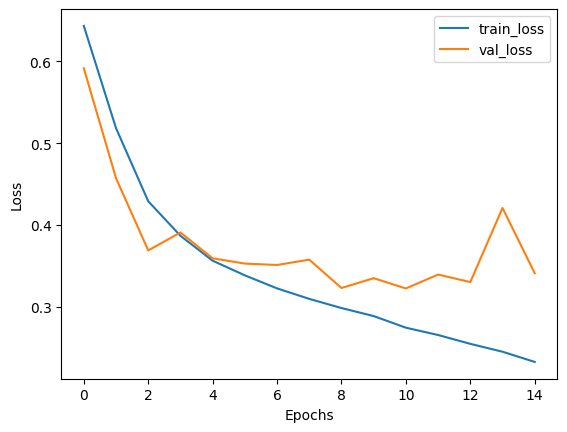

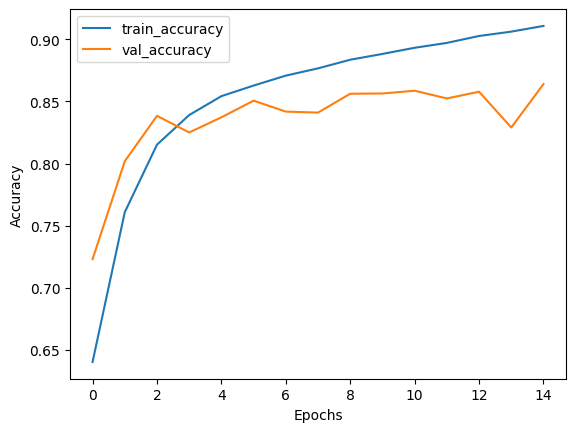

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.8586000204086304, 'false_negatives': 390.0, 'false_positives': 317.0, 'loss': 0.3296171724796295}
----------------------------------------------------------------------------------------------------


In [ ]:

def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset.batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=4, verbose=1),
            keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.h5", verbose=1, save_best_only=True
            ),
        ],
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = keras.models.load_model("FullModelCheckpoint.h5")

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model


# Sampling the full train dataset to train on
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

# Training the full model
full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)

# Tarning via Active Learning

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 150, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,537 (1.63 MB)

 Trainable params: 426,537 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Starting to train with 15000 samples
Epoch 1/20
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.5187 - false_negatives_1: 1514.4912 - false_positives_1: 2024.9474 - loss: 0.6924
Epoch 1: val_loss improved from inf to 0.67939, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - binary_accuracy: 0.5197 - false_negatives_1: 1600.9166 - false_positives_1: 2106.6499 - loss: 0.6923 - val_binary_accuracy: 0.6132 - val_false_negatives_1: 232.0000 - val_false_positives_1: 1702.0000 - val_loss: 0.6794
Epoch 2/20
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.6328 - false_negatives_1: 1091.5518 - false_positives_1: 1630.6034 - loss: 0.6645
Epoch 2: val_loss improved from 0.67939 to 0.57611, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - binary_accuracy: 0.6335 - false_negatives_1: 1124.0667 - false_positives_1: 1680.3500 - loss: 0.6638 - val_binary_accuracy: 0.7382 - val_false_negatives_1: 918.0000 - val_false_positives_1: 391.0000 - val_loss: 0.5761
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.6976 - false_negatives_1: 896.0000 - false_positives_1: 1356.3051 - loss: 0.5914
Epoch 3: val_loss did not improve from 0.57611
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.6978 - false_negatives_1: 908.9333 - false_positives_1: 1377.7000 - loss: 0.5911 - val_binary_accuracy: 0.6760 - val_false_negatives_1: 150.0000 - val_false_positives_1: 1470.0000 - val_loss: 0.5862
Epoch 4/20
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.7535 - false_negatives_1: 647.7193 - false_positives_1: 1147.0702 - loss: 0.5239
Epoch 4: val_loss improved from 0.57611 to 0.53027, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.7539 - false_negatives_1: 682.2000 - false_positives_1: 1201.1000 - loss: 0.5233 - val_binary_accuracy: 0.7200 - val_false_negatives_1: 99.0000 - val_false_positives_1: 1301.0000 - val_loss: 0.5303
Epoch 5/20
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.7788 - false_negatives_1: 688.4483 - false_positives_1: 932.9828 - loss: 0.4828
Epoch 5: val_loss did not improve from 0.53027
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.7792 - false_negatives_1: 709.8000 - false_positives_1: 961.7500 - loss: 0.4822 - val_binary_accuracy: 0.7088 - val_false_negatives_1: 63.0000 - val_false_positives_1: 1393.0000 - val_loss: 0.5620
Epoch 6/20
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.7987 - false_negatives_1: 609.2241 - false_positives_1: 862.6379 - loss: 0.4483
Epoch 6: val_loss improved from 0.53027 to 0.41534, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - binary_accuracy: 0.7991 - false_negatives_1: 628.2833 - false_positives_1: 889.7167 - loss: 0.4478 - val_binary_accuracy: 0.8064 - val_false_negatives_1: 226.0000 - val_false_positives_1: 742.0000 - val_loss: 0.4153
Epoch 7/20
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8379 - false_negatives_1: 523.3104 - false_positives_1: 715.7414 - loss: 0.3923
Epoch 7: val_loss improved from 0.41534 to 0.39315, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.8378 - false_negatives_1: 540.3666 - false_positives_1: 740.4167 - loss: 0.3925 - val_binary_accuracy: 0.8244 - val_false_negatives_1: 258.0000 - val_false_positives_1: 620.0000 - val_loss: 0.3932
Epoch 8/20
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8376 - false_negatives_1: 532.0172 - false_positives_1: 679.0862 - loss: 0.3836
Epoch 8: val_loss did not improve from 0.39315
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - binary_accuracy: 0.8378 - false_negatives_1: 548.7500 - false_positives_1: 700.7167 - loss: 0.3833 - val_binary_accuracy: 0.8160 - val_false_negatives_1: 680.0000 - val_false_positives_1: 240.0000 - val_loss: 0.4132
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.8552 - false_negatives_1: 499.8983 - false_positives_1: 606.9153 - loss: 0.3626
Epoch 9: val_loss improved from 0.39315 to 0.36897, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - binary_accuracy: 0.8552 - false_negatives_1: 507.6833 - false_positives_1: 616.7167 - loss: 0.3625 - val_binary_accuracy: 0.8430 - val_false_negatives_1: 401.0000 - val_false_positives_1: 384.0000 - val_loss: 0.3690
Epoch 10/20
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8641 - false_negatives_1: 461.6897 - false_positives_1: 575.0172 - loss: 0.3395
Epoch 10: val_loss improved from 0.36897 to 0.36846, saving model to AL_Model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.8640 - false_negatives_1: 477.4333 - false_positives_1: 594.1500 - loss: 0.3396 - val_binary_accuracy: 0.8408 - val_false_negatives_1: 321.0000 - val_false_positives_1: 475.0000 - val_loss: 0.3685
Epoch 11/20
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8687 - false_negatives_1: 436.0702 - false_positives_1: 516.8596 - loss: 0.3281
Epoch 11: val_loss did not improve from 0.36846
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.8690 - false_negatives_1: 457.1667 - false_positives_1: 541.8500 - loss: 0.3279 - val_binary_accuracy: 0.8132 - val_false_negatives_1: 155.0000 - val_false_positives_1: 779.0000 - val_loss: 0.4217
Epoch 12/20
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8744 - false_negatives_1: 405.1754 - false_positives_1: 505.1930 - loss: 0.3190
Epoch 12: val_loss did not improve from 0.36846
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.8746 - false_negative

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
----------------------------------------------------------------------------------------------------
Number of zeros incorrectly classified: 343.0, Number of ones incorrectly classified: 448.0
Sample ratio for positives: 0.5663716814159292, Sample ratio for negatives:0.4336283185840708
Starting training with 24998 samples
----------------------------------------------------------------------------------------------------
Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.8453 - false_negatives_3: 811.7551 - false_positives_3: 1059.2041 - loss: 0.3965
Epoch 1: val_loss improved from 0.36846 to 0.35999, saving model to AL_Model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - binary_accuracy: 0.8454 - false_negatives_3: 819.3737 - false_positives_3: 1069.1515 - loss: 0.3962 - val_binary_accuracy: 0.8460 - val_false_negatives_3: 284.0000 - val_false_positives_3: 486.0000 - val_loss: 0.3600
Epoch 2/20
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8635 - false_negatives_3: 747.9175 - false_positives_3: 969.2681 - loss: 0.3419
Epoch 2: val_loss did not improve from 0.35999
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - binary_accuracy: 0.8636 - false_negatives_3: 762.5051 - false_positives_3: 988.1111 - loss: 0.3418 - val_binary_accuracy: 0.7958 - val_false_negatives_3: 889.0000 - val_false_positives_3: 132.0000 - val_loss: 0.4403
Epoch 3/20
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.8731 - false_negatives_3: 713.1855 - false_positives_3: 854.1855 - loss: 0.3229
Epoch 3: val_loss did not improve from 0.35999
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_accuracy: 0.8731 - false_negatives_

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.8939 - false_negatives_3: 612.5959 - false_positives_3: 757.1212 - loss: 0.2872 - val_binary_accuracy: 0.8510 - val_false_negatives_3: 426.0000 - val_false_positives_3: 319.0000 - val_loss: 0.3445
Epoch 6/20
96/98 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8990 - false_negatives_3: 569.0833 - false_positives_3: 698.7812 - loss: 0.2711
Epoch 6: val_loss did not improve from 0.34450
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.8990 - false_negatives_3: 586.7475 - false_positives_3: 720.1616 - loss: 0.2713 - val_binary_accuracy: 0.8502 - val_false_negatives_3: 384.0000 - val_false_positives_3: 365.0000 - val_loss: 0.3591
Epoch 7/20
97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.9053 - false_negatives_3: 555.1547 - false_positives_3: 645.1237 - loss: 0.2595
Epoch 7: val_loss did not improve from 0.34450
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.9053 - false_negatives_3:

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
----------------------------------------------------------------------------------------------------
Number of zeros incorrectly classified: 452.0, Number of ones incorrectly classified: 327.0
Sample ratio for positives: 0.4197689345314506, Sample ratio for negatives:0.5802310654685494
Starting training with 29997 samples
----------------------------------------------------------------------------------------------------
Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.8815 - false_negatives_4: 797.7119 - false_positives_4: 970.6102 - loss: 0.3106
Epoch 1: val_loss did not improve from 0.34450
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - binary_accuracy: 0.8815 - false_negatives_4: 804.2353 - false_positives_4: 978.4958 - loss: 0.3105 - val_binary_accuracy: 0.8502 - val_false_negatives_4: 228.0000 - val_false_positives_4: 521.0000 - val_loss: 0.3517
Epoch 2/20
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.9034 - false_negatives_4: 690.3278 - false_positives_4: 775.9580 - loss: 0.2581 - val_binary_accuracy: 0.8520 - val_false_negatives_4: 314.0000 - val_false_positives_4: 426.0000 - val_loss: 0.3373
Epoch 4/20
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.9143 - false_negatives_4: 610.3419 - false_positives_4: 715.8718 - loss: 0.2451
Epoch 4: val_loss did not improve from 0.33729
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - binary_accuracy: 0.9142 - false_negatives_4: 621.3278 - false_positives_4: 728.7143 - loss: 0.2452 - val_binary_accuracy: 0.8438 - val_false_negatives_4: 558.0000 - val_false_positives_4: 223.0000 - val_loss: 0.3688
Epoch 5/20
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.9212 - false_negatives_4: 579.8034 - false_positives_4: 644.3589 - loss: 0.2222
Epoch 5: val_loss did not improve from 0.33729
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.9211 - false_ne

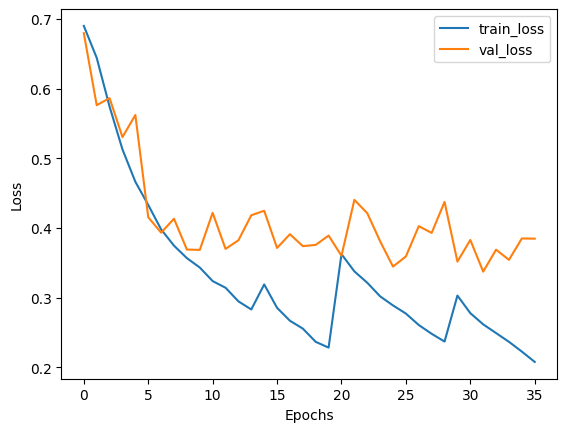

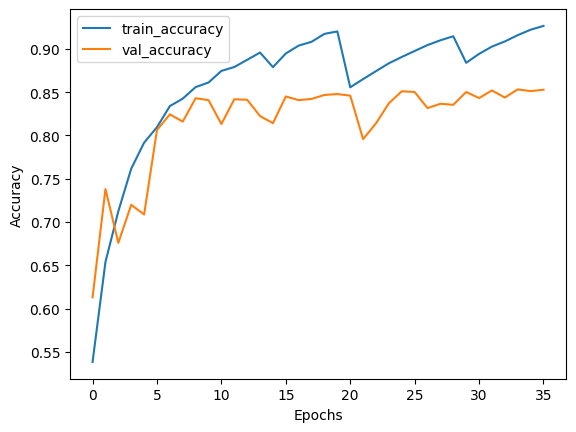

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.8528000116348267, 'false_negatives_4': 335.0, 'false_positives_4': 401.0, 'loss': 0.33934488892555237}
----------------------------------------------------------------------------------------------------


In [8]:

def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=5000,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "AL_Model.h5", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Generating labels from the output probabilities
        rounded = tf.where(tf.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )
        history = model.fit(
            train_dataset.cache().shuffle(20000).batch(256),
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=4, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model("AL_Model.h5")

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model


active_learning_model = train_active_learning_models(
    train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset
)